In [159]:
import numpy as np
import pandas as pd
import torch
import h5py
import matplotlib.pyplot as plt

In [160]:
from transformers import AutoformerConfig, AutoformerModel

In [165]:
signal_path = '/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Gaby/MetaData_ForMike/vmshell_redo_FPdata/Day6_ActiveAvoidanceShuttleBox-230621/570_1d_2d-230621-111320/570_1d_2d-230621-111320_output_1/z_score_DA.hdf5'
cue_path = '/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Gaby/MetaData_ForMike/vmshell_redo_FPdata/Day6_ActiveAvoidanceShuttleBox-230621/570_1d_2d-230621-111320/570_1d_2d-230621-111320_output_1/Cue_DA.hdf5'
timestamps_path = '/Volumes/fsmresfiles/Basic_Sciences/Phys/Lerner_Lab_tnl2633/Gaby/MetaData_ForMike/vmshell_redo_FPdata/Day6_ActiveAvoidanceShuttleBox-230621/570_1d_2d-230621-111320/570_1d_2d-230621-111320_output_1/timeCorrection_DA.hdf5'


In [166]:
with h5py.File(cue_path, "r") as f:
    print(f.keys())

<KeysViewHDF5 ['ts']>


In [167]:
with h5py.File(cue_path, "r") as f:
    print(f['ts'][:])

[ 300.19133186  362.29160714  410.74171638  463.12185597  505.46188021
  537.76195335  574.68215036  631.65226746  665.17229319  707.87243772
  771.0725708   820.24275708  857.92284417  915.89287686  968.48305917
 1006.35320067 1069.5733223  1105.56339979 1161.02356744 1217.71368194
 1264.79376125 1307.77390838 1341.05390859 1377.07396865 1439.68411398
 1495.97413111 1542.734231   1584.25440001 1637.95443463 1694.57458949]


In [168]:


def fetch_data(key, path):
    with h5py.File(path, "r") as f:
        data = f[key][:]
    return np.array(data)


        
data_dict= {
    'signal': fetch_data('data', signal_path),
    'cue_times': fetch_data('ts', cue_path),
    'timestamps': fetch_data('timestampNew', timestamps_path)
}

df = (pd.DataFrame.from_dict(data_dict, orient = 'index')
      .T
    #   .assign(cue_times = lambda df_: df_.cue_times.fillna(0))
)
df

,signal,cue_times,timestamps
0,2.018120,300.191332,1.000735
1,2.030112,362.291607,1.001718
2,2.042099,410.741716,1.002701
3,2.054075,463.121856,1.003684
4,2.066034,505.461880,1.004667
...,...,...,...
2088705,0.652899,NaN,2054.281298
2088706,0.651586,NaN,2054.282281
2088707,0.650271,NaN,2054.283264
2088708,0.648954,NaN,2054.284247


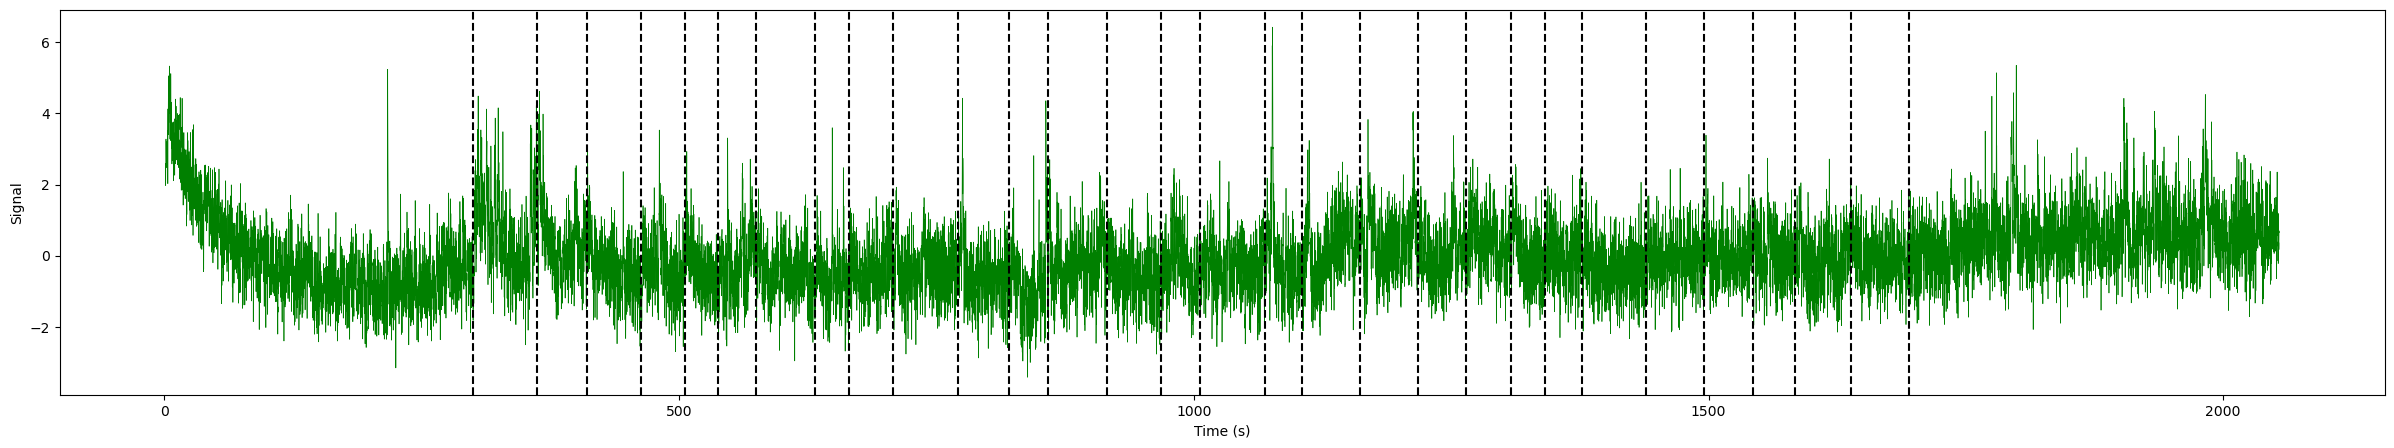

In [6]:
fig, ax = plt.subplots(figsize=(30, 5))
ax.plot(df['timestamps'], df['signal'], color = 'g', linewidth = 0.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Signal')
for ts in df['cue_times'].dropna():
    ax.axvline(ts, color='k', linewidth=1.5, linestyle='--')
    

In [174]:
cue_times = df['cue_times'].dropna().to_numpy()
timestamps = df['timestamps'].to_numpy()

# Broadcasting the comparison between each element in cue_times and all elements in timestamps
# close_matrix = np.isclose(cue_times[:, None], timestamps, atol=1e-9)

# # Checking if each element in cue_times is close to any element in timestamps
# df['cue_vector'] = close_matrix.any(axis=1)

# print(df)

In [175]:
cue_times

array([ 300.19133186,  362.29160714,  410.74171638,  463.12185597,
        505.46188021,  537.76195335,  574.68215036,  631.65226746,
        665.17229319,  707.87243772,  771.0725708 ,  820.24275708,
        857.92284417,  915.89287686,  968.48305917, 1006.35320067,
       1069.5733223 , 1105.56339979, 1161.02356744, 1217.71368194,
       1264.79376125, 1307.77390838, 1341.05390859, 1377.07396865,
       1439.68411398, 1495.97413111, 1542.734231  , 1584.25440001,
       1637.95443463, 1694.57458949])

In [177]:
sparse_vec = np.zeros_like(timestamps)
for value in cue_times:
    closest_index = np.argmin(np.abs(timestamps- value))
    sparse_vec[closest_index] = 1
sparse_vec.sum()

30.0

In [179]:
def create_sparse_vector(df, from_column, aligned_column):
    
    from_column_arr = df[from_column].dropna().to_numpy()
    aligned_column_arr = df[aligned_column].to_numpy()
    
    sparse_vec = np.zeros_like(aligned_column_arr)
    
    for value in from_column_arr:
        closest_index = np.argmin(np.abs(aligned_column_arr - value))
        sparse_vec[closest_index] = 1
    return sparse_vec

sparse_vec = create_sparse_vector(df, 'cue_times', 'timestamps')



In [190]:
np.where(timestamps >= cue_times[0])

(array([ 304353,  304354,  304355, ..., 2088707, 2088708, 2088709]),)

In [194]:
df = df.assign(cue_vector = lambda df_: create_sparse_vector(df_, 'cue_times', 'timestamps'))
df

,signal,cue_times,timestamps,cue_vector
0,2.018120,300.191332,1.000735,0.0
1,2.030112,362.291607,1.001718,0.0
2,2.042099,410.741716,1.002701,0.0
3,2.054075,463.121856,1.003684,0.0
4,2.066034,505.461880,1.004667,0.0
...,...,...,...,...
2088705,0.652899,NaN,2054.281298,0.0
2088706,0.651586,NaN,2054.282281,0.0
2088707,0.650271,NaN,2054.283264,0.0
2088708,0.648954,NaN,2054.284247,0.0


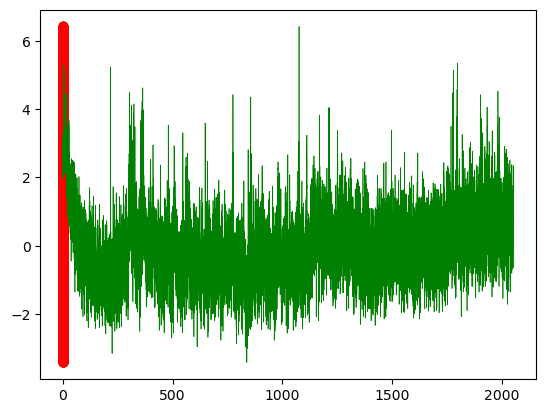

In [198]:
plt.plot(df['timestamps'], df['signal'], color = 'g', linewidth = 0.5)


array([300.19133186, 362.29160714, 410.74171638, 463.12185597,
       505.46188021, 537.76195335, 574.68215036, 631.65226746,
       665.17229319, 707.87243772])

pandas.core.series.Series